<a href="https://colab.research.google.com/github/biolytic1996/python-learning1996/blob/master/1115_%E6%88%BF%E5%83%B9%E9%A0%90%E6%B8%AC%E7%B7%B4%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 實驗一：房價預測模型

### Import必要套件

In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

## Step 1. 設定 Google Drive 連接 

In [6]:
from google.colab import drive
drive.mount('/content/gdrive') # 點擊網址，選擇 Google 帳號登入，然後將授權碼貼回輸入框中

Mounted at /content/gdrive


In [13]:
!ln -fs /content/gdrive/My\ Drive/ /app  #執行一次就可，否則會有錯誤訊息

In [14]:
%cd /app

/content/gdrive/My Drive


### https://www.kaggle.com/shivachandel/kc-house-data
### http://www.stodolkiewicz.com/2020/01/28/tensorflow-2-regression-on-the-boston-housing-dataset-part-2-keras-callbacks/

### 步驟 2. 下載 cuDNN 檔案

1. 申請 Nvidia 帳號，申請網址為 http://bit.ly/2qfpOPj
2. 下載 `cudnn-10.0-linux-x64-v7.5.0.56.tgz`，下載網址為 
下載 cuDNN 檔案。下載網址為：http://bit.ly/2qfpOPj
3. 將下載的檔案 `cudnn-10.0-linux-x64-v7.5.0.56.tgz` 放到 google drive 的 `Colab Notebooks/cuDNN/` 目錄下。

In [ ]:
!tar -xzvf /app/cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

# 檢查是否安裝成功
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 5
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


### 數據讀取並分析

In [15]:
data = pd.read_csv("/app/kc_house_data.csv")
# 顯示dataset的形狀，共21613比資料，每一比資料有21種不同資訊。
data.shape

(21613, 21)

In [16]:
# 將顯示列數設定為25，不然會有部份資料無法顯示
pd.options.display.max_columns = 25
# head 會顯示前五行的數據
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


各個數據的簡寫分別代表下面意思：
- date：房屋出售日期。
- price：房屋價格（目標）。
- bedrooms：臥室數量。
- bathrooms：浴室數量。
- sqft_living：居住的坪數（平方英尺）。
- sqft_lot：實際的坪數（平方英尺）。
- floors：房屋總共樓層。
- waterfront：海景房。
- view：房屋是否看過。
- condition：整體條件有多好。
- grade：房屋的整體等級（根據King County評分系統）。
- sqft_above：除了地下室外的坪數（平方英尺）。
- sqft_basement：地下室的坪數（平方英尺）。
- yr_built：房屋建造時間。
- yr_renovated：何時重新裝修過（一些沒重新裝修過或是裝修紀錄沒被記錄到的數值都為0）。
- zipcode：郵政編碼。
- lat：緯度座標。
- long：經度座標。
- sqft_living15：2015年紀錄的居住坪數（可能是翻新的原因導致sqft_living15與sqft_living不同）。
- sqft_lot15：2015年紀錄的實際坪數（可能是翻新的原因導致sqft_lot15與sqft_lot不同）。

### 檢查資料的型態

資料型態總共有五種：object(string),booleab, integer, float and categorical.

In [17]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above       float64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

date20141013T000000是物件  要處理

### 數據前處理
轉換資料型態：
因為數據集裡的date數據是字串（string）格式，而模型的輸入只接受數值格式，所以可以透過以下程式碼將其轉為數值，並分成年、月及日三種數據。

In [ ]:
# 將date日期拆為年、月和日並轉成數值
data['year'] = pd.to_numeric(data['date'].str.slice(0, 4))#新增year欄位儲存 將原本的資料轉文字再切片擷取
data['month'] = pd.to_numeric(data['date'].str.slice(4, 6))
data['day'] = pd.to_numeric(data['date'].str.slice(6, 8))

# 刪除沒有用的數據，inplace則是將更新後的資料存回原本的地方
data.drop(['id'], axis="columns", inplace=True)
data.drop(['date'], axis="columns", inplace=True)

data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


分割數據集（Dataset）：將數據集切割成三個部份，訓練數據（Training data）、驗證數據（Validation data）和測試數據（Testing data）。

In [ ]:
data_num = data.shape[0]
# 取得一筆與data數量相同的亂數索引，主要目的是用於打散資料
indexes = np.random.permutation(data_num)
# 並將亂數索引值分為Train、validation和test分為，這裡的劃分比例為6:2:2
train_indexes = indexes[:int(data_num *0.6)]
val_indexes = indexes[int(data_num *0.6):int(data_num *0.8)]
test_indexes = indexes[int(data_num *0.8):]
# 透過索引值從data取出訓練資料、驗證資料和測試資料
train_data = data.loc[train_indexes]
val_data = data.loc[val_indexes]
test_data = data.loc[test_indexes]

### Normalization 正規化

使用標準分數(Standard Score, 又稱z-score)將數據正規化，經過z-score正規化後數據的都會聚集在0附近， 標準差為1。 

(x - 平均值) / 標準差

In [ ]:
train_validation_data = pd.concat([train_data, val_data])
mean = train_validation_data.mean()
std = train_validation_data.std()

train_data = (train_data - mean) / std
val_data = (val_data - mean) / std

### 建立Numpy array格式的訓練數據

In [ ]:
x_train = np.array(train_data.drop('price', axis='columns'))
y_train = np.array(train_data['price'])
x_val = np.array(val_data.drop('price', axis='columns'))
y_val = np.array(val_data['price'])

整理過後的資料共12967筆，且一筆資料有21種資訊(所以網路輸入必須為21)。

In [ ]:
x_train.shape

(12967, 21)

### 建立並訓練網路模型

這裡建構三層全連接層的網路架構，並且使用ReLU作為隱藏層的激活函數，而由於需得到線性輸出，故輸出層不使用任何激活函數。

In [ ]:
# 建立一個Sequential型態的model
model = keras.Sequential(name='model-1')
# 第1層全連接層設為64個unit，將輸入形狀設定為(21, )，而實際上我們輸入的數據形狀為(batch_size, 21)
model.add(layers.Dense(21, activation='relu', input_shape=(21,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
# 最後一層全連接層設為1個unit
model.add(layers.Dense(1))
# 顯示網路模型架構
model.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 21)                462       
_________________________________________________________________
dense_27 (Dense)             (None, 64)                1408      
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 6,095
Trainable params: 6,095
Non-trainable params: 0
_________________________________________________________________


設定訓練使用的優化器、損失函數和指標函數：

In [ ]:
model.compile(keras.optimizers.Adam(0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

創建模型儲存目錄：

In [ ]:
model_dir = '/app/lab2-logs/models/'
%cd /app
!rm -rf lab2-logs
os.makedirs(model_dir)

/content/gdrive/My Drive/Tensorflow2/MMSLAB-TF2


設定回調函數：

訓練網路模型：

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# TensorBoard回調函數會幫忙紀錄訓練資訊，並存成TensorBoard的紀錄檔
log_dir = os.path.join('/app/lab2-logs', 'model-1')
# patience: number of epochs that produced the monitored quantity with no improvement after which training will be stopped.
# Simply speaking - If there is no improvement in mse on the test set after any 15 epochs -> stop the training procedure
monitor_val_acc = EarlyStopping(monitor = 'val_loss', patience=15)

# save the best model ( = lowest mse) to a file 'best_model.hdf5'
modelCheckpoint = ModelCheckpoint(model_dir + '/Best-model-1.h5', save_best_only = True)
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# pass the above callbacks to callbacks parameter
history = model.fit(x_train, y_train, 
                batch_size=64,  # 批次大小設為64
                epochs=300,  # 整個dataset訓練300遍
                validation_data=(x_val, y_val), 
                callbacks=[monitor_val_acc, modelCheckpoint])

Epoch 1/300
203/203 [==============================] - 1s 4ms/step - loss: 0.5368 - mean_absolute_error: 0.4581 - val_loss: 1.1092 - val_mean_absolute_error: 0.6603
Epoch 2/300
203/203 [==============================] - 1s 3ms/step - loss: 0.9638 - mean_absolute_error: 0.6370 - val_loss: 1.1092 - val_mean_absolute_error: 0.6600
Epoch 3/300
203/203 [==============================] - 1s 3ms/step - loss: 0.9636 - mean_absolute_error: 0.6381 - val_loss: 1.1114 - val_mean_absolute_error: 0.6497
Epoch 4/300
203/203 [==============================] - 1s 3ms/step - loss: 0.9637 - mean_absolute_error: 0.6368 - val_loss: 1.1103 - val_mean_absolute_error: 0.6529
Epoch 5/300
203/203 [==============================] - 1s 3ms/step - loss: 0.9639 - mean_absolute_error: 0.6373 - val_loss: 1.1095 - val_mean_absolute_error: 0.6566
Epoch 6/300
203/203 [==============================] - 1s 3ms/step - loss: 0.9639 - mean_absolute_error: 0.6366 - val_loss: 1.1099 - val_mean_absolute_error: 0.6547
Epoch 7/30

### 原課本程式 (執行階段發生錯誤)

### 訓練結果

In [ ]:
history.history.keys()  # 查看history儲存的資訊有哪些

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

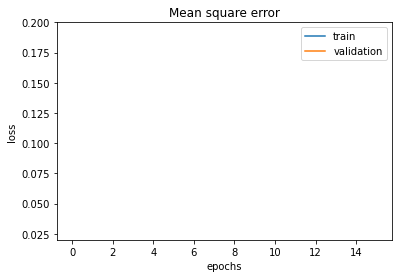

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0.02, 0.2)
plt.title('Mean square error')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

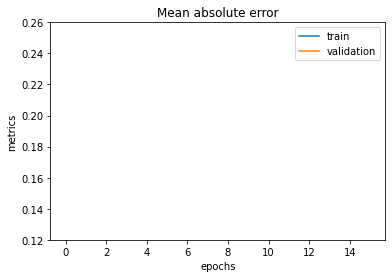

In [ ]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='validation')
plt.ylim(0.12, 0.26)
plt.title('Mean absolute error')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

測試數據的誤差百分比：用測試數據預測房屋價格並與答案計算誤差百分比。

In [ ]:
# 載入模型
model = keras.models.load_model('/app/lab2-logs/models/Best-model-1.h5')
# 先將房屋價格取出
y_test = np.array(test_data['price'])
# 標準化數據
test_data = (test_data - mean) / std
# 將輸入數據存成Numpy 格式
x_test = np.array(test_data.drop('price', axis='columns'))
# 預測測試數據
y_pred = model.predict(x_test)
# 將預測結果轉換回來(因為訓練時的訓練目標也有經過標準化)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
# 計算平均的誤差百分比
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
# 顯示誤差百分比
print("Model_1 Percentage Error: {:.2f}%".format(percentage_error))

Model_1 Percentage Error: 43.38%


### TensorBoard 可視化工具

In [ ]:
# 這行指令可以幫助我們直接在jupyter notebook上顯示TensorBoard
%reload_ext tensorboard

In [ ]:
%tensorboard --port 9530 --logdir /app/lab2-logs

# 實驗二：過擬合問題

### 方法一、減少網路權重

In [ ]:
model_2 = keras.Sequential(name='model-2')
model_2.add(layers.Dense(16, activation='relu', input_shape=(21,)))
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dense(1))

model_2.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_2.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Epoch 1/300
203/203 [==============================] - 1s 5ms/step - loss: 0.9318 - mean_absolute_error: 0.6234 - val_loss: 1.1104 - val_mean_absolute_error: 0.6527
Epoch 2/300
203/203 [==============================] - 1s 3ms/step - loss: 0.9635 - mean_absolute_error: 0.6351 - val_loss: 1.1099 - val_mean_absolute_error: 0.6547
Epoch 3/300
203/203 [==============================] - 1s 3ms/step - loss: 0.9634 - mean_absolute_error: 0.6384 - val_loss: 1.1102 - val_mean_absolute_error: 0.6533
Epoch 4/300
203/203 [==============================] - 1s 3ms/step - loss: 0.9636 - mean_absolute_error: 0.6363 - val_loss: 1.1101 - val_mean_absolute_error: 0.6538
Epoch 5/300
203/203 [==============================] - 1s 3ms/step - loss: 0.9634 - mean_absolute_error: 0.6373 - val_loss: 1.1101 - val_mean_absolute_error: 0.6536
Epoch 6/300
203/203 [==============================] - 1s 3ms/step - loss: 0.9635 - mean_absolute_error: 0.6358 - val_loss: 1.1097 - val_mean_absolute_error: 0.6555
Epoch 7/30

### 加入L1或L2 正則化

In [ ]:
model_3 = keras.Sequential(name='model-3')
model_3.add(layers.Dense(64, 
                         kernel_regularizer=keras.regularizers.l2(0.001), 
                         activation='relu', input_shape=(21,)))
model_3.add(layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model_3.add(layers.Dense(1))

model_3.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_3.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Epoch 1/300
203/203 [==============================] - 1s 4ms/step - loss: nan - mean_absolute_error: 0.6248 - val_loss: nan - val_mean_absolute_error: 0.6572
Epoch 2/300
203/203 [==============================] - 1s 3ms/step - loss: nan - mean_absolute_error: 0.6370 - val_loss: nan - val_mean_absolute_error: 0.6544
Epoch 3/300
203/203 [==============================] - 1s 3ms/step - loss: nan - mean_absolute_error: 0.6371 - val_loss: nan - val_mean_absolute_error: 0.6538
Epoch 4/300
203/203 [==============================] - 1s 3ms/step - loss: nan - mean_absolute_error: 0.6359 - val_loss: nan - val_mean_absolute_error: 0.6553
Epoch 5/300
203/203 [==============================] - 1s 3ms/step - loss: nan - mean_absolute_error: 0.6379 - val_loss: nan - val_mean_absolute_error: 0.6547
Epoch 6/300
203/203 [==============================] - 1s 3ms/step - loss: nan - mean_absolute_error: 0.6364 - val_loss: nan - val_mean_absolute_error: 0.6564
Epoch 7/300
203/203 [=========================

### 加入 Dropout

In [ ]:
model_4 = keras.Sequential(name='model-4')
model_4.add(layers.Dense(64, activation='relu', input_shape=(21,)))
model_4.add(layers.Dropout(0.3))
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dropout(0.3))
model_4.add(layers.Dense(1))

model_4.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-4')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-4.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_4.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Epoch 1/300
203/203 [==============================] - 1s 4ms/step - loss: 0.5601 - mean_absolute_error: 0.4822 - val_loss: 1.1143 - val_mean_absolute_error: 0.6445
Epoch 2/300
203/203 [==============================] - 1s 3ms/step - loss: 0.9637 - mean_absolute_error: 0.6339 - val_loss: 1.1099 - val_mean_absolute_error: 0.6544
Epoch 3/300
203/203 [==============================] - 1s 3ms/step - loss: 0.9635 - mean_absolute_error: 0.6374 - val_loss: 1.1101 - val_mean_absolute_error: 0.6538
Epoch 4/300
203/203 [==============================] - 1s 3ms/step - loss: 0.9635 - mean_absolute_error: 0.6352 - val_loss: 1.1097 - val_mean_absolute_error: 0.6557
Epoch 5/300
203/203 [==============================] - 1s 3ms/step - loss: 0.9635 - mean_absolute_error: 0.6375 - val_loss: 1.1097 - val_mean_absolute_error: 0.6555
Epoch 6/300
203/203 [==============================] - 1s 3ms/step - loss: 0.9635 - mean_absolute_error: 0.6366 - val_loss: 1.1098 - val_mean_absolute_error: 0.6550
Epoch 7/30

### 驗證正則化的效能

Test model 2:

In [ ]:
model_2 = keras.models.load_model('/app/lab2-logs/models/Best-model-2.h5')
y_pred = model_2.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_2: {:.2f}%".format(percentage_error))

Model_2: 42.86%


Test model 3:

In [ ]:
model_3 = keras.models.load_model('/app/lab2-logs/models/Best-model-3.h5')
y_pred = model_3.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_3: {:.2f}%".format(percentage_error))

Model_3: 42.73%


Test model 4:

In [ ]:
model_4 = keras.models.load_model('/app/lab2-logs/models/Best-model-4.h5')
y_pred = model_4.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_4: {:.2f}%".format(percentage_error))

Model_4: 42.31%


In [ ]:
!curl ipecho.net/plain

35.225.38.180